In [7]:
import sys
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))

from utils.simulation import Simulation
from training.train import train_and_validate, evaluate_model

In [2]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())

Is CUDA enabled? False
Number of GPUs 0


In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.fc1(x))  # Activation function (ReLU) after first layer
        x = F.relu(self.fc2(x))  # Activation function (ReLU) after second layer
        x = self.fc3(x)          # Output layer
        return x

In [4]:
mlp = MLP(2, 256, 1)

In [5]:
## Can be removed once turned into .py file.
def train_mlp(model,
              sim_amount=1,
              training_size=0.8,
              batch_size=4,
              num_epochs = 200,
              lr = 0.0005,
              criterion = nn.MSELoss(),
              optimizer = optim.AdamW,
              model_name = 'babie_first_RNN'):
    
    """
    This method trains a simple MLP. Given the waterlevel at t=0 and topography (both 64*64), the MLP predicts the waterlevel at the end of the simulation step ahead. The best model state is
    saved following the save_path, and also returned by the method.
    
    Description of arguments:
    - model: the model to be trained, should be an instance of the class SimpleRNN;
    - sim_amount (int): number of simulations of which the data is loaded and used for training, with a maximum of 400;
    - training_size (float): fraction of data to use for training (validation uses the fraction 1 - training_size);
    - batch_size (int): batch size used during training (you can modify this based on your requirements);
    - num_epochs (int): number of epochs used during training;
    - lr (float): learning rate used during training;
    - criterion: Loss function, default nn.MSELoss()
    - optimizer: optimizer used for training, default optim.AdamW
    - model_name (string): the best model state will be saved in ../results/trained_models/ under this name

    returns: model, train_losses, val_losses, best_val_loss, time
    """
    # load simulations to be used for training
    sims = Simulation.load_simulations(str(root)+"/data/processed_data/normalized_training_data", sim_amount=sim_amount, number_grids=64)

    n_timesteps = 96
    grid_size = 64
    channels = 2   # water depth and topography

    # reformat the data
    X = np.zeros((len(sims), grid_size, grid_size, channels))   # timestep * grid_x * grid_y * channels
    Y = np.zeros(X[:,:,:,0].shape)   # timestep * grid_x * grid_y

    for i in range(len(sims)):   # number of simulations loaded in for training/validation

        sim = sims[i]            # get simulation
        topography = sim.topography
    
        wd,*_ = sim.return_timestep(0)
        X[i,:,:,0] = wd
        X[i,:,:,1] = topography

        wd, *_ = sim.return_timestep(-1)
        Y[i,:,:] = wd

    # split the data into training and validation
    id_training = int(training_size * len(X))

    X_tra = X[:id_training, :]
    Y_tra = Y[:id_training, :]

    X_val = X[id_training:, :]
    Y_val = Y[id_training:, :]

    print("X_tra.shape: ", X_tra.shape)
    print("Y_tra.shape: ", Y_tra.shape)
    print("X_val.shape: ", X_val.shape)
    print("Y_val.shape: ", Y_val.shape)

    #create datasets and data loaders
    train_dataset = TensorDataset(torch.tensor(X_tra, dtype=torch.float32), torch.tensor(Y_tra, dtype=torch.float32).unsqueeze(-1))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32).unsqueeze(-1))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # defining the optimizer
    optimizer = optimizer(model.parameters(), lr=lr)

    # defining the save path
    save_path = "../results/trained_models/" + model_name

    # training
    train_losses, val_losses, best_val_loss, time = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path)

    # Load the best model
    model.load_state_dict(torch.load(save_path))

    return model, train_losses, val_losses, best_val_loss, time

In [6]:
train_mlp(mlp,
          sim_amount=20,
          training_size=0.8,
          batch_size=4,
          num_epochs = 10,
          lr = 0.0005,
          criterion = nn.MSELoss(),
          optimizer = optim.AdamW,
          model_name = 'mlp')

X_tra.shape:  (16, 64, 64, 2)
Y_tra.shape:  (16, 64, 64)
X_val.shape:  (4, 64, 64, 2)
Y_val.shape:  (4, 64, 64)
Training complete.


(MLP(
   (fc1): Linear(in_features=2, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=256, bias=True)
   (fc3): Linear(in_features=256, out_features=1, bias=True)
 ),
 [0.01580215711146593,
  0.01113334740512073,
  0.010722202248871326,
  0.008729718392714858,
  0.009407298872247338,
  0.008446847787126899,
  0.008679102407768369,
  0.008396819466724992,
  0.008348081493750215,
  0.00835073902271688],
 [0.015321815386414528,
  0.00948223378509283,
  0.009446105919778347,
  0.009476746432483196,
  0.008372534066438675,
  0.00895558763295412,
  0.00821441039443016,
  0.008534363470971584,
  0.008276252076029778,
  0.008279728703200817],
 0.00821441039443016,
 87.09094333648682)

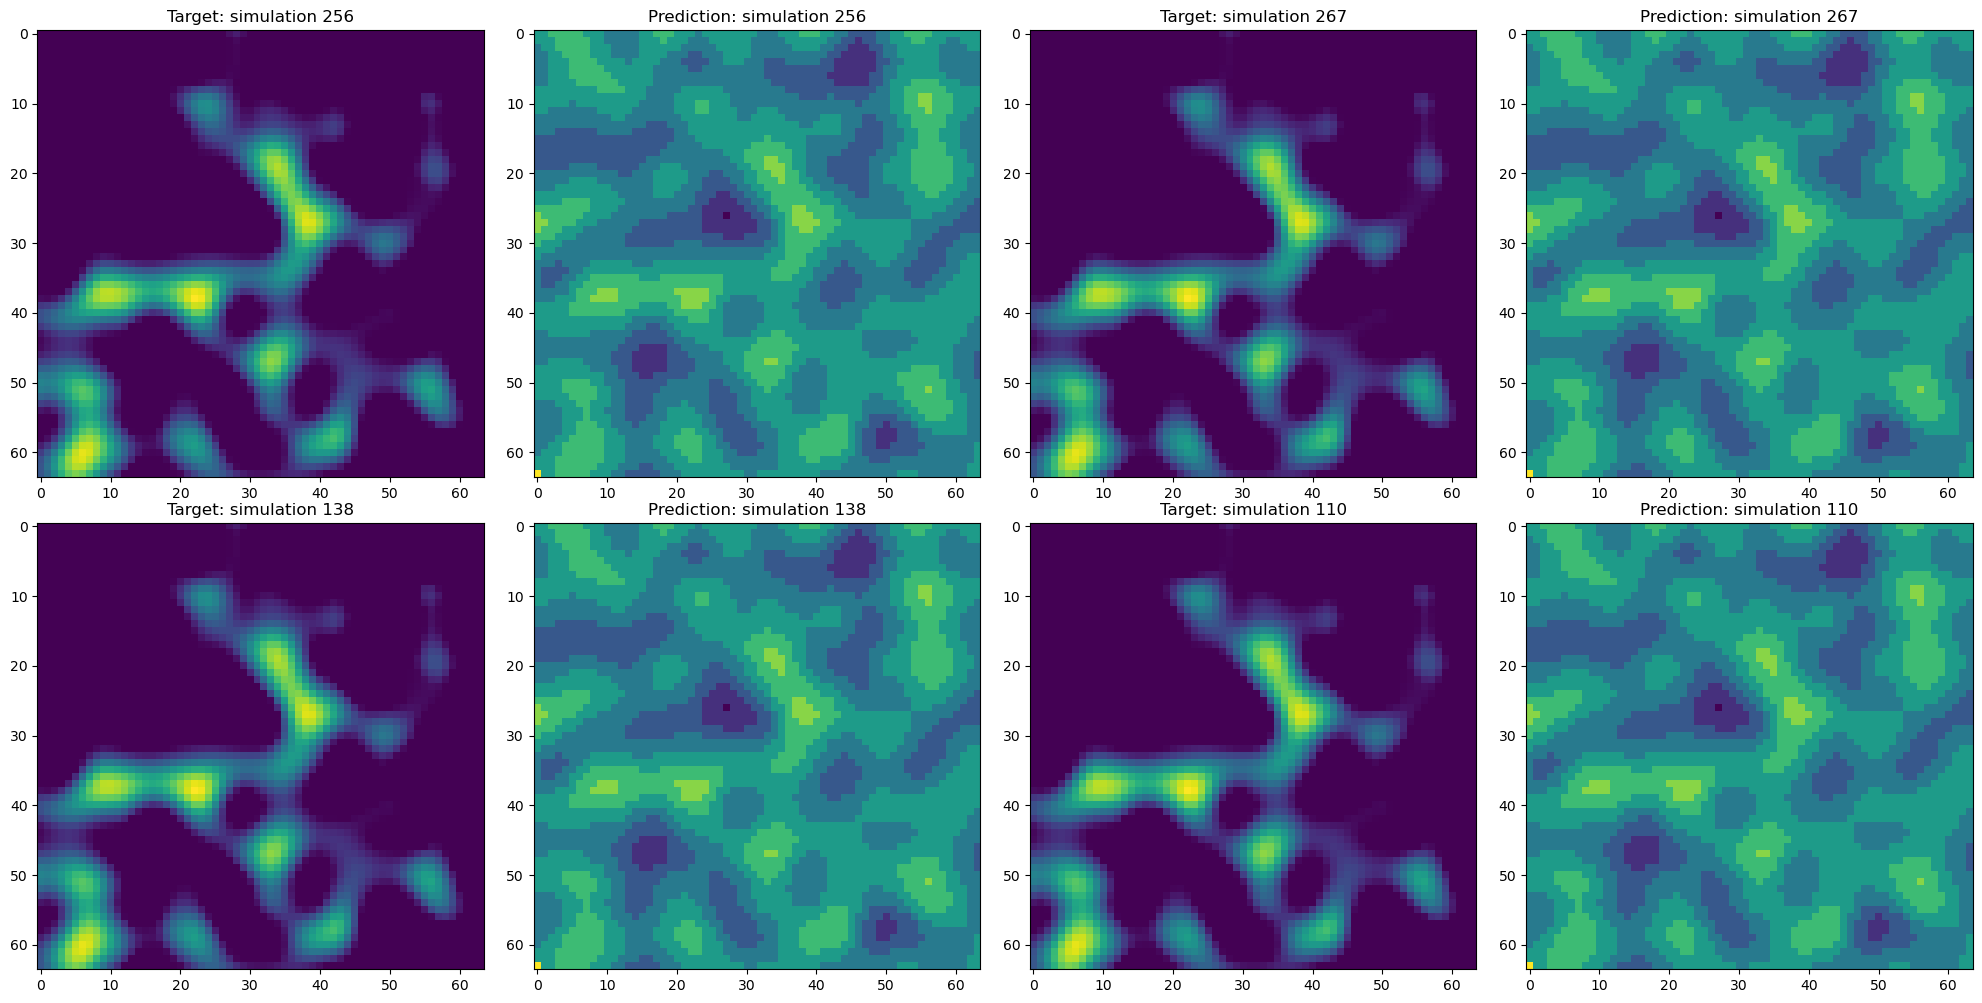

In [19]:
mlp.eval()

grid_size = 64
channels = 2

f,axs = plt.subplots(2, 4, figsize=(20,10))
axs = axs.reshape(-1)

for i in range(0, len(axs), 2):
  with torch.no_grad():
      # Randomly select a simulation
      random_index = random.randint(0, 280)
      sim = Simulation.load_simulation(str(root)+"/data/processed_data/normalized_training_data", 
                                       random_index, 
                                       grid_size)

      inputs = np.zeros((grid_size, grid_size, channels))
      targets = np.zeros((grid_size, grid_size))
    
      inputs[:,:,0] = sim.return_timestep(0)[0]
      inputs[:,:,1] = sim.topography
      targets[:,:,] = sim.return_timestep(-1)[0]

      # inputs, target = inputs.to(device).unsqueeze(0), target.to(device).unsqueeze(0)

      # Predict
      inputs = torch.tensor(inputs, dtype=torch.float32)
      prediction = mlp(inputs)

      # Plotting inputs (time series)
      axs[i].imshow(targets)
      axs[i+1].imshow(prediction)

      axs[i].set_title(f"Target: simulation {random_index}")
      axs[i+1].set_title(f"Prediction: simulation {random_index}")

f.tight_layout()

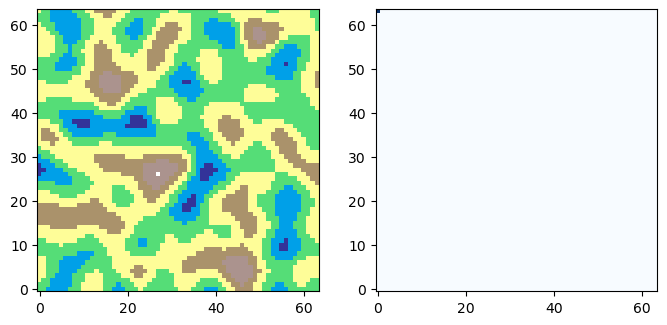

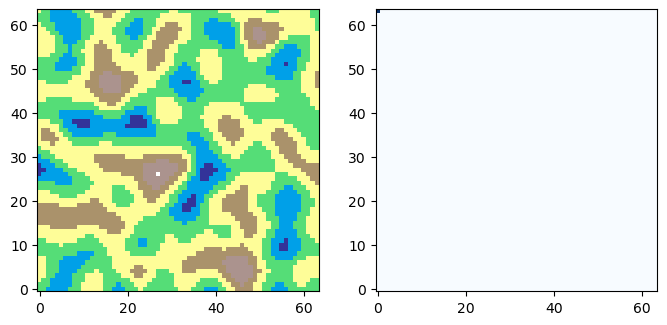

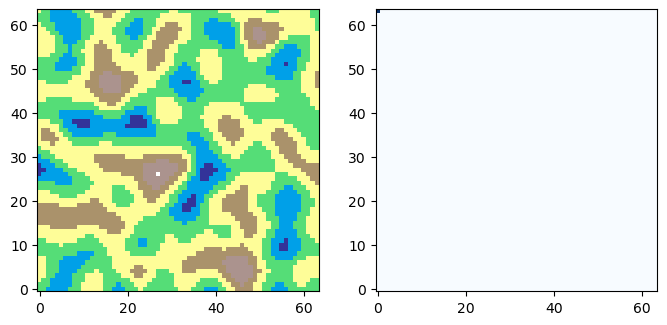

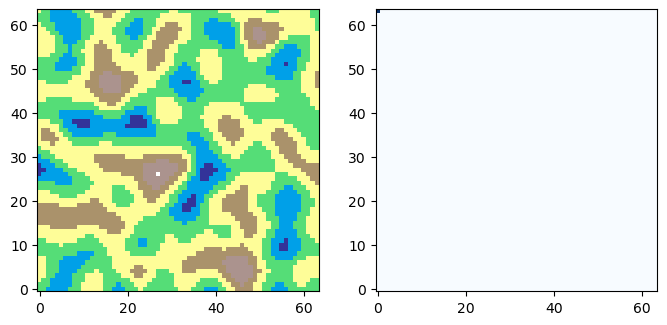

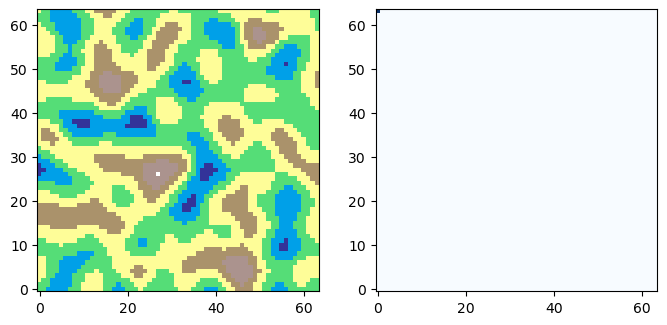

In [24]:
for i in range(5):
    sim = Simulation.load_simulation(str(root)+"/data/processed_data/normalized_training_data", 
                                       i, 
                                       grid_size)
